In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

Código en ensamblador que efectua el producto interno entre dos vectores de float.

In [3]:
%%file asmFloatInnerProd.asm
    global asmFloatInnerProd
    section .text

asmFloatInnerProd:
    xorpd xmm0, xmm0
    xorpd xmm1, xmm1
    xorpd xmm2,xmm2
    cmp rdx, 0
    je done
next:
    movss xmm0, [rdi]
    movss xmm1, [rsi]
    mulss xmm0, xmm1
    addss xmm2, xmm0
    add rdi, 4
    add rsi, 4
    sub rdx, 1
    jnz next
done:
    movss xmm0, xmm2
    ret

Writing asmFloatInnerProd.asm


Archivo de cabecera de la función en ensamblador para explicitar los parámetros y sus tipos de dato

In [4]:
%%file asmFloatInnerProd.c
extern float asmFloatInnerProd(float *v1, float *v2, int N);

Writing asmFloatInnerProd.c


Reglas para generar la librería compartida que se vinculará con Python

In [5]:
! nasm -f elf64 -g asmFloatInnerProd.asm -o asmFloatInnerProd.o
! gcc -shared asmFloatInnerProd.o asmFloatInnerProd.c -o asmFloatInnerProd.so

In [6]:
import ctypes

Función que vincula la librería compartida en ASM con Python

In [7]:
def ctypes_asmFloatInnerProd():
    # indicar la ruta de la shared library
    libfile = './asmFloatInnerProd.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.asmFloatInnerProd.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float32),
        np.ctypeslib.ndpointer(dtype=np.float32),
        ctypes.c_int
    ]
    
    # tipo de dato que devuelve
    lib.asmFloatInnerProd.restype = ctypes.c_float
    
    # funcion configurada
    return lib.asmFloatInnerProd

In [8]:
%%file cFloatInnerProd.c
float cFloatInnerProd(float *v1, float *v2, int N)
{
    float sum = 0;
    for (int i = 0; i < N; i++)
    {
        sum += v1[i] * v2[i];
    }
    return sum;
}

Writing cFloatInnerProd.c


Reglas para generar la librería compartida del código en C

In [9]:
! gcc -c -Wall -Werror -fpic cFloatInnerProd.c
! gcc -shared cFloatInnerProd.o -o cFloatInnerProd.so

Función que vincula la librería compartida en C con Python

In [10]:
def ctypes_cFloatInnerProd():
    # indicar la ruta de la shared library
    libfile = './cFloatInnerProd.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.cFloatInnerProd.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float32),
        np.ctypeslib.ndpointer(dtype=np.float32),
        ctypes.c_int
    ]
    
    # tipo de dato que devuelve
    lib.cFloatInnerProd.restype = ctypes.c_float
    
    # funcion configurada
    return lib.cFloatInnerProd

Prueba de las dos funciones

In [11]:
# tam
size = 2048

# entradas
x = np.random.rand(size,1).astype(np.float32)
y = np.random.rand(size,1).astype(np.float32)

In [12]:
asmFloatInnerProd = ctypes_asmFloatInnerProd()

In [13]:
cFloatInnerProd = ctypes_cFloatInnerProd()

In [14]:
asmFloatInnerProd(x,y,size) == cFloatInnerProd(x,y,size)

True

Función auxiliar llamada filtro mediana

In [15]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

Variables donde estarán las mediciones

In [16]:
# modulo para medir el tiempo
import time

# tamagnos de los arreglos
sizes = 2**np.arange(11,18)

# tiempos de la suma de arreglos de floats en C
tc = np.zeros((len(sizes),1),dtype=np.float32)

# tiempos de la suma de arreglos de floats en ASM
tasm = np.zeros((len(sizes),1),dtype=np.float32)

# tiempo con ruido en C
tcr = np.zeros((len(sizes),1),dtype=np.float32)

# tiempo con ruido en ASM
tasmr = np.zeros((len(sizes),1),dtype=np.float32)

Mediciones para el caso más pequegno

In [17]:
# primero el caso más pequeño
veces = 40
tam = sizes[0]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = np.random.rand(tam,1).astype(np.float32)
    yp = np.random.rand(tam,1).astype(np.float32)
    
    # tiempo C
    t = time.time()
    rc = cFloatInnerProd(xp,yp,tam)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    rasm = asmFloatInnerProd(xp,yp,tam)
    tasmp.append(time.time() - t)

Gráficas para las mediciones del caso más pequegno

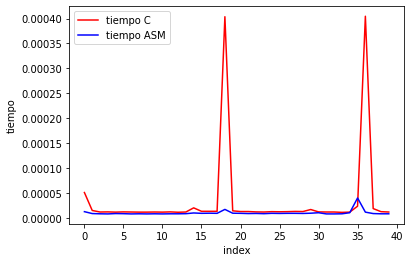

In [18]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
plt.show()

Gráficos de los mediciones sin ruido para distintos tamagno de ventana

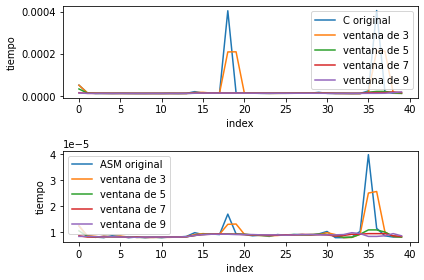

In [19]:
# primero los tiempos de C
plt.subplot(2,1,1)
plt.plot(index, tcp, label='C original')
plt.plot(index, filtro_mediana(tcp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tcp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tcp,7), label='ventana de 7')
plt.plot(index, filtro_mediana(tcp,9), label='ventana de 9')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# luego los tiempos de ASM
plt.subplot(2,1,2)
plt.plot(index, tasmp, label='ASM original')
plt.plot(index, filtro_mediana(tasmp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tasmp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tasmp,7), label='ventana de 7')
plt.plot(index, filtro_mediana(tasmp,9), label='ventana de 9')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# para evitar que los gráficos estén muy pegados
plt.tight_layout()

Comparación del promedio con ruido y sin ruido en el caso pequegno de la función en C y ASM

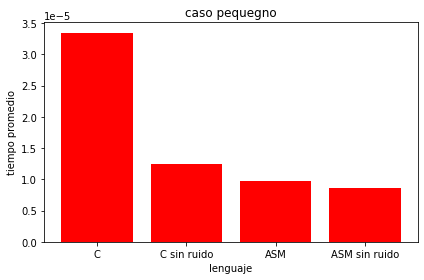

In [20]:
noms = ['C','C sin ruido','ASM','ASM sin ruido']
proms = [ 
    statistics.mean(tcp), 
    statistics.mean(filtro_mediana(tcp,9)),
    statistics.mean(tasmp), 
    statistics.mean(filtro_mediana(tasmp,9))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.title('caso pequegno')
plt.tight_layout()

Mediciones para el caso mas grande

In [21]:
# primero el caso más grande
veces = 40
tam = sizes[-1]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = np.random.rand(tam,1).astype(np.float32)
    yp = np.random.rand(tam,1).astype(np.float32)
    
    # tiempo C
    t = time.time()
    rc = cFloatInnerProd(xp,yp,tam)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    rasm = asmFloatInnerProd(xp,yp,tam)
    tasmp.append(time.time() - t)

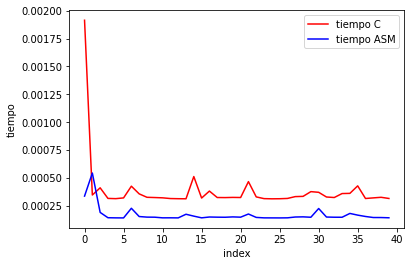

In [22]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
plt.show()

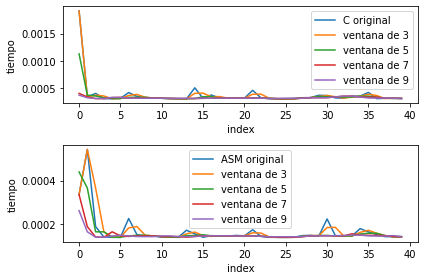

In [23]:
# primero los tiempos de C
plt.subplot(2,1,1)
plt.plot(index, tcp, label='C original')
plt.plot(index, filtro_mediana(tcp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tcp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tcp,7), label='ventana de 7')
plt.plot(index, filtro_mediana(tcp,9), label='ventana de 9')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# luego los tiempos de ASM
plt.subplot(2,1,2)
plt.plot(index, tasmp, label='ASM original')
plt.plot(index, filtro_mediana(tasmp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tasmp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tasmp,7), label='ventana de 7')
plt.plot(index, filtro_mediana(tasmp,9), label='ventana de 9')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# para evitar que los gráficos estén muy pegados
plt.tight_layout()

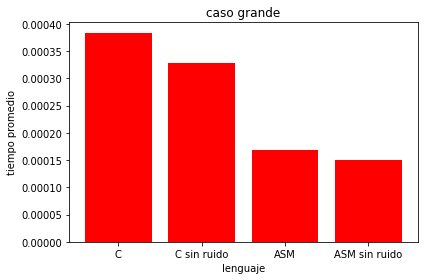

In [24]:
noms = ['C','C sin ruido','ASM','ASM sin ruido']
proms = [ 
    statistics.mean(tcp), 
    statistics.mean(filtro_mediana(tcp,9)),
    statistics.mean(tasmp), 
    statistics.mean(filtro_mediana(tasmp,9))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.title('caso grande')
plt.tight_layout()

In [25]:
# caso general
for i, size in enumerate(sizes):
    tci = []
    tasmi = []
    for j in range(veces):
        # entradas
        x = np.random.rand(size,1).astype(np.float32)
        y = np.random.rand(size,1).astype(np.float32)
    
        # tiempo C
        t = time.time()
        rc = cFloatInnerProd(x,y,size)
        tci.append(time.time() - t)
    
        # tiempo ASM
        t = time.time()
        rasm = asmFloatInnerProd(x,y,size)
        tasmi.append(time.time() - t)
    
    tc[i] = statistics.mean(filtro_mediana(tci,7))
    tasm[i] = statistics.mean(filtro_mediana(tasmi,7))
    
    tcr[i] = statistics.mean(tci) 
    tasmr[i] = statistics.mean(tasmi) 

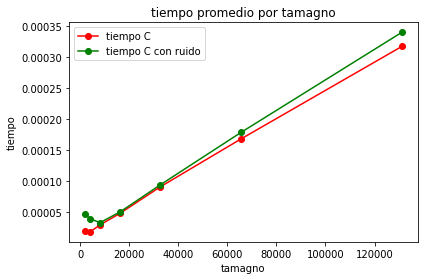

In [26]:
plt.plot(sizes, tc, 'r-o', label='tiempo C')
plt.plot(sizes, tcr, 'g-o', label='tiempo C con ruido')
plt.title('tiempo promedio por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.tight_layout()
plt.show()

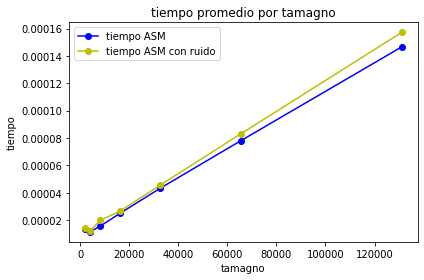

In [27]:
plt.plot(sizes, tasm, 'b-o', label='tiempo ASM')
plt.plot(sizes, tasmr, 'y-o', label='tiempo ASM con ruido')
plt.title('tiempo promedio por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.tight_layout()
plt.show()

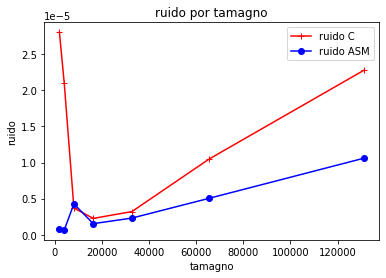

In [28]:
plt.plot(sizes, tcr-tc, 'r-+', label='ruido C')
plt.plot(sizes, tasmr-tasm, 'b-o', label='ruido ASM')
plt.title('ruido por tamagno')
plt.xlabel('tamagno')
plt.ylabel('ruido')
plt.legend()
plt.show()

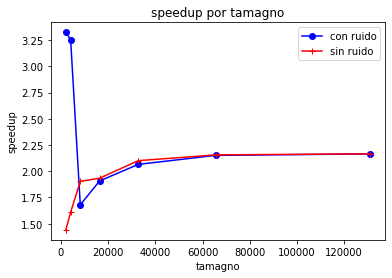

In [29]:
plt.plot(sizes, tcr/tasmr, 'b-o', label='con ruido')
plt.plot(sizes, tc/tasm, 'r-+', label='sin ruido')
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()

In [30]:
%%file main.c
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <time.h>

extern float asmFloatInnerProd(float *v1, float *v2, int N);

float cFloatInnerProd(float *v1, float *v2, int N)
{
    float sum = 0;
    for (int i = 0; i < N; i++)
    {
        sum += v1[i] * v2[i];
    }
    return sum;
}

void initVector(float *v, int N)
{
    for (int i = 0; i < N; i++)
    {
        float e = random() % 255;
        v[i] = (sinf(e) + cosf(e));
    }
}

int main(int argc, char** argv)
{
    if (argc != 2)
    {
        printf("Error\n");
        printf("Ejemplo de uso:\n");
        printf("%s 4",argv[0]);
        return 1;
    }
    
    int N = atoi(argv[1]);
    
    srandom(time(NULL));

    float *x, *y;

    x = malloc(N * sizeof(float));

    y = malloc(N * sizeof(float));
    
    initVector(x, N);
    initVector(y, N);
    
    float rasm = asmFloatInnerProd(x,y,N);
    float rc = cFloatInnerProd(x,y,N);
    
    printf("resultados: %f\t%f\n",rc,rasm);
    
    return 0;
}

Writing main.c


In [31]:
! gcc -g asmFloatInnerProd.o main.c -lm

In [32]:
! ./a.out

Error
Ejemplo de uso:
./a.out 4

In [33]:
! ./a.out 4

resultados: 0.210651	0.210651


In [34]:
%%file main.gdb
set logging file main.txt

set logging on

set pagination off

set args 4

file a.out

b main

b 54

r

c

print *x@N

print *y@N

c

q

Writing main.gdb


Limpieza de archivos

In [36]:
! rm *.o
! rm *.so
! rm *.asm
! rm *.c
! rm *.gdb
! rm *.txt

rm: cannot remove '*.txt': No such file or directory
